### 访问哥白尼气候变化服务 (C3S) 的气候数据存储 (CDS) 中的数据，并分析近地表气温的气候学和趋势。

本教程包括以下步骤：

1. 搜索、下载和查看数据

2. 计算气候正常值

3. 可视化与正常情况相关的异常

4. 计算每月的气候和异常

5. 查看时间序列并分析趋势

In [1]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

#### 搜索、下载和查看数据
- 本教程所需的数据是1979 年至今的 ERA5 单级月平均数据。ERA5 是 ECMWF 再分析数据集的第 5 版。再分析使用最先进的预测模型和数据同化系统来创建过去几十年观测和建模的气候变量的一致“无间隙地图”
- [数据链接：ECMWF中的CDS库的“1979至今ERA5单层月平均数据”](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview)

In [ ]:
import cdsapi

dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["2m_temperature"],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [72, -25, 34, 40]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-03-17 01:30:35,052 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-17 01:30:35,053 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-17 01:30:36,699 INFO Request ID is 47920ec9-c4eb-476c-9b93-3ffccf7da568
2025-03-17 01:30:37,303 INFO status has been updated to accepted
2025-03-17 01:30:43,857 INFO status has been updated to running
2025-03-17 01:30:47,953 INFO status has been updated to successful


'e335452e7f59ab06347a7206f61eef72.nc'

In [2]:
ds = xr.open_dataset('e335452e7f59ab06347a7206f61eef72.nc')
ds

<xarray.Dataset> Size: 81MB
Dimensions:     (valid_time: 504, latitude: 153, longitude: 261)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2020-12-01
  * latitude    (latitude) float64 1kB 72.0 71.75 71.5 71.25 ... 34.5 34.25 34.0
  * longitude   (longitude) float64 2kB -25.0 -24.75 -24.5 ... 39.5 39.75 40.0
    expver      (valid_time) <U4 8kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 81MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

- 将经度转换[-180，180]的网格
  
默认情况下，ECMWF 数据位于 [0, 360] 网格上。ECMWF（ERA5等数据）：默认使用 0°–360° 的经度范围（避免负数，简化存储），但 NetCDF-CF标准、Cartopy、Matplotlib 等工具默认使用 -180°–180° 的范围
> 有两种方法可以将经度坐标带到网格中。第一种方法是使用 xarray 函数为坐标分配值;第二种选择是，area在使用请求数据时指定关键字参数。然后，关键字会自动将请求的数据重新投影到 [-180, 180] 网格上

In [3]:
ds_180 = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')
# Create Xarray Data Array
da = ds_180['t2m']
da

<xarray.DataArray 't2m' (valid_time: 504, latitude: 153, longitude: 261)> Size: 81MB
[20126232 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2020-12-01
  * latitude    (latitude) float64 1kB 72.0 71.75 71.5 71.25 ... 34.5 34.25 34.0
    expver      (valid_time) <U4 8kB ...
  * longitude   (longitude) float64 2kB -25.0 -24.75 -24.5 ... 39.5 39.75 40.0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      39933
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

- 将温度单位从开尔文改为摄氏度

请注意，ERA-5 温度数据的单位是Kelvin，这是国际单位制 (SI) 中温度的基本单位。如果想将值转换摄氏度，则必须减去 273.15。

In [4]:
da_degc = da - 273.15
#如果您检查上述数据的特征，您会发现，当您转换数据值时，数据数组的属性会被删除。
#但是，我们希望保留属性提供的信息，
#因此，我们使用函数assign_attrs()从上一个未转换的对象重新分配属性。由于单位已更改，我们为单位属性分配了一个新的单位度量。
da_degc = da_degc.assign_attrs(da.attrs)
da_degc.attrs['units'] = '° C'
da_degc

<xarray.DataArray 't2m' (valid_time: 504, latitude: 153, longitude: 261)> Size: 81MB
array([[[-24.49141   , -22.903519  , -22.35469   , ...,  -7.104706  ,
          -7.108612  ,  -7.135956  ],
        [-25.184769  , -23.567581  , -21.9543    , ...,  -6.84494   ,
          -6.870331  ,  -6.8976746 ],
        [-21.501175  , -21.36641   , -20.92305   , ...,  -6.5675964 ,
          -6.5968933 ,  -6.6340027 ],
        ...,
        [ 15.826935  ,  15.803497  ,  15.78006   , ...,   8.387482  ,
           8.65506   ,   8.938263  ],
        [ 15.946075  ,  15.926544  ,  15.90506   , ...,   8.076935  ,
           8.393341  ,   8.731232  ],
        [ 16.049591  ,  16.028107  ,  16.010529  , ...,   7.8034973 ,
           8.114044  ,   8.487091  ]],

       [[-22.35231   , -21.22145   , -20.729263  , ..., -10.442169  ,
         -10.594513  , -10.783966  ],
        [-22.453873  , -21.301529  , -20.153091  , ..., -10.285919  ,
         -10.477325  , -10.668732  ],
        [-19.848404  , -19.899185  , -19.735123  , ..., -10.084747  ,
         -10.31131   , -10.56131   ],
...
        [ 19.289825  ,  19.258575  ,  19.221466  , ...,  15.004669  ,
          15.213654  ,  15.340607  ],
        [ 19.395294  ,  19.362091  ,  19.319122  , ...,  14.789825  ,
          15.05545   ,  15.303497  ],
        [ 19.477325  ,  19.446075  ,  19.40506   , ...,  14.576935  ,
          14.846466  ,  15.143341  ]],

       [[-19.679031  , -18.077469  , -17.362625  , ...,  -0.51498413,
          -0.5188904 ,  -0.55404663],
        [-20.089188  , -18.460281  , -16.833344  , ...,  -0.34701538,
          -0.38217163,  -0.41732788],
        [-17.08139   , -16.563812  , -15.917328  , ...,  -0.23568726,
          -0.26498413,  -0.294281  ],
        ...,
        [ 17.617828  ,  17.617828  ,  17.627594  , ...,  10.983063  ,
          11.2760315 ,  11.498688  ],
        [ 17.692047  ,  17.695953  ,  17.711578  , ...,  10.9635315 ,
          11.2291565 ,  11.596344  ],
        [ 17.748688  ,  17.758453  ,  17.777985  , ...,  10.848297  ,
          11.1354065 ,  11.48111   ]]], dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2020-12-01
  * latitude    (latitude) float64 1kB 72.0 71.75 71.5 71.25 ... 34.5 34.25 34.0
    expver      (valid_time) <U4 8kB ...
  * longitude   (longitude) float64 2kB -25.0 -24.75 -24.5 ... 39.5 39.75 40.0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      39933
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    ° C
    standard_name:                            unknown
    GRIB_surface:                             0.0

- 绘制数据可视化
  
现在，让我们可视化一个时间步骤，以更好地了解数据。xarray 提供内置的 matplotlib 函数，允许您绘制DataArray。使用函数plot()，您可以轻松绘制加载数组的第一个时间步骤。
> 内置 xarray 绘图函数的替代方法是使用绘图库matplotlib和Cartopy的组合。Cartopy 的主要功能之一是它能够将数组数据转换为不同的地理投影。与 matplotlib 结合使用，它是创建高质量可视化和动画的一种非常强大的方法。

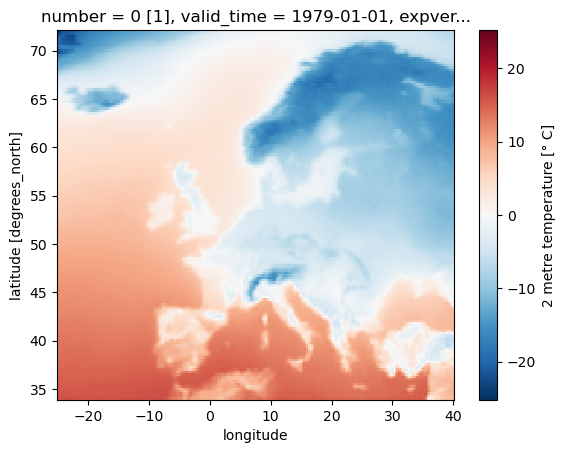

In [5]:
da_degc[0,:,:].plot()

#### 计算气候平均值
> 标准参考期和气候正常值

数年到数十年的人类活动和自然变化塑造了地球的气候。为了评估特定月份或年份的异常情况，世界气象组织 (WMO) 定义了用于创建的。可以被视为正常值所基于的时期的典型气候。到 2020 年为止，最常用和最广泛的标准参考期是 1981-2010 年的 30 年范围。随着 2021 年的开始，WMO 建议将气候正常参考期更新为 1991-2020 年范围。

首先，让我们计算参考期 1991-2020 年的近地表气温气候标准。为此，我们将为每年创建平均近地表气温。您可以使用 xarray 函数groupby()按年份对数据进行分组（指定time.year），然后使用函数创建每年的平均值mean()。生成的对象包含从 1979 年到 2020 年每年的全球平均年地表气温


In [6]:
print(da_degc.valid_time.dtype) 
yearly_mean = da_degc.groupby('valid_time.year').mean(keep_attrs=True)
yearly_mean

datetime64[ns]


<xarray.DataArray 't2m' (year: 42, latitude: 153, longitude: 261)> Size: 7MB
array([[[-14.6370325 , -13.1892805 , -12.310536  , ...,  -1.589508  ,
          -1.6536356 ,  -1.7358297 ],
        [-15.057769  , -13.582021  , -12.111806  , ...,  -1.3004456 ,
          -1.3832906 ,  -1.4667867 ],
        [-11.407703  , -11.283355  , -10.92398   , ...,  -1.0244039 ,
          -1.1074117 ,  -1.1980692 ],
        ...,
        [ 18.972342  ,  18.935232  ,  18.896658  , ...,  19.936697  ,
          20.222504  ,  20.51124   ],
        [ 19.064463  ,  19.030283  ,  18.992035  , ...,  19.50294   ,
          19.876638  ,  20.25831   ],
        [ 19.139334  ,  19.108246  ,  19.07309   , ...,  19.230154  ,
          19.599619  ,  20.044281  ]],

       [[-14.002895  , -12.554653  , -11.756476  , ...,   0.1217804 ,
           0.11868795,   0.10355123],
        [-14.540656  , -13.065884  , -11.595669  , ...,   0.33564758,
           0.32099915,   0.3063507 ],
        [-11.308234  , -11.186489  , -10.83216   , ...,   0.54739887,
           0.53763324,   0.52086896],
...
        [ 20.078257  ,  20.046682  ,  20.013968  , ...,  20.911428  ,
          21.254852  ,  21.564749  ],
        [ 20.165823  ,  20.13262   ,  20.09616   , ...,  20.512827  ,
          20.934378  ,  21.322886  ],
        [ 20.24118   ,  20.205698  ,  20.171682  , ...,  20.1987    ,
          20.608856  ,  21.078745  ]],

       [[-13.12083   , -11.474509  , -10.457746  , ...,   2.5095394 ,
           2.5297215 ,   2.5251644 ],
        [-13.382874  , -11.706931  , -10.035546  , ...,   2.734637  ,
           2.7302425 ,   2.7260106 ],
        [ -9.563378  ,  -9.152409  ,  -8.602441  , ...,   2.921486  ,
           2.9239273 ,   2.9253922 ],
        ...,
        [ 19.785582  ,  19.757586  ,  19.732847  , ...,  21.373472  ,
          21.648537  ,  21.892351  ],
        [ 19.86696   ,  19.840105  ,  19.814714  , ...,  20.954039  ,
          21.325294  ,  21.704851  ],
        [ 19.942808  ,  19.920347  ,  19.897234  , ...,  20.656187  ,
          21.038023  ,  21.50775   ]]], dtype=float32)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 1kB 72.0 71.75 71.5 71.25 ... 34.5 34.25 34.0
  * longitude  (longitude) float64 2kB -25.0 -24.75 -24.5 ... 39.5 39.75 40.0
  * year       (year) int64 336B 1979 1980 1981 1982 ... 2017 2018 2019 2020
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      39933
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    ° C
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [7]:
yearly_mean = da_degc.groupby('valid_time.year').mean(keep_attrs=True)
ref = yearly_mean.where((yearly_mean.year > 1990) & (yearly_mean.year < 2021), drop=True)
ref_mean = ref.mean(dim="year", keep_attrs=True)
ref_mean

<xarray.DataArray 't2m' (latitude: 153, longitude: 261)> Size: 160kB
array([[-13.050894 , -11.423008 , -10.442882 , ...,   1.4398503,
          1.4387543,   1.4215018],
       [-13.385747 , -11.727298 , -10.074355 , ...,   1.6178178,
          1.600549 ,   1.582911 ],
       [ -9.3567   ,  -9.119232 ,  -8.715977 , ...,   1.7936698,
          1.7839255,   1.7696679],
       ...,
       [ 19.475447 ,  19.445639 ,  19.41946  , ...,  20.093609 ,
         20.371143 ,  20.641459 ],
       [ 19.557947 ,  19.529978 ,  19.503288 , ...,  19.653175 ,
         20.020947 ,  20.372759 ],
       [ 19.633982 ,  19.61083  ,  19.586237 , ...,  19.340061 ,
         19.70219  ,  20.133528 ]], dtype=float32)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 1kB 72.0 71.75 71.5 71.25 ... 34.5 34.25 34.0
  * longitude  (longitude) float64 2kB -25.0 -24.75 -24.5 ... 39.5 39.75 40.0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      39933
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    ° C
    standard_name:                            unknown
    GRIB_surface:                             0.0

- 异常计算

下一步是计算特定年份相对于气候正常的异常值。术语“异常”是指某个值与长期平均值的偏差。正异常或负异常分别表示特定年份的平均温度比参考值高或低。
让我们计算一下 2016 年的近地表气温异常。首先，我们从 xarray.DataArray 对象中选择 2016 年的平均近地表温度值yearly_mean。使用 xarray 函数sel()，您可以根据坐标标签选择一个数据数组。感兴趣的坐标标签是year=2016。

In [8]:
t2m_2016 = yearly_mean.sel(year=2016)
anom_2016 = t2m_2016 - ref_mean

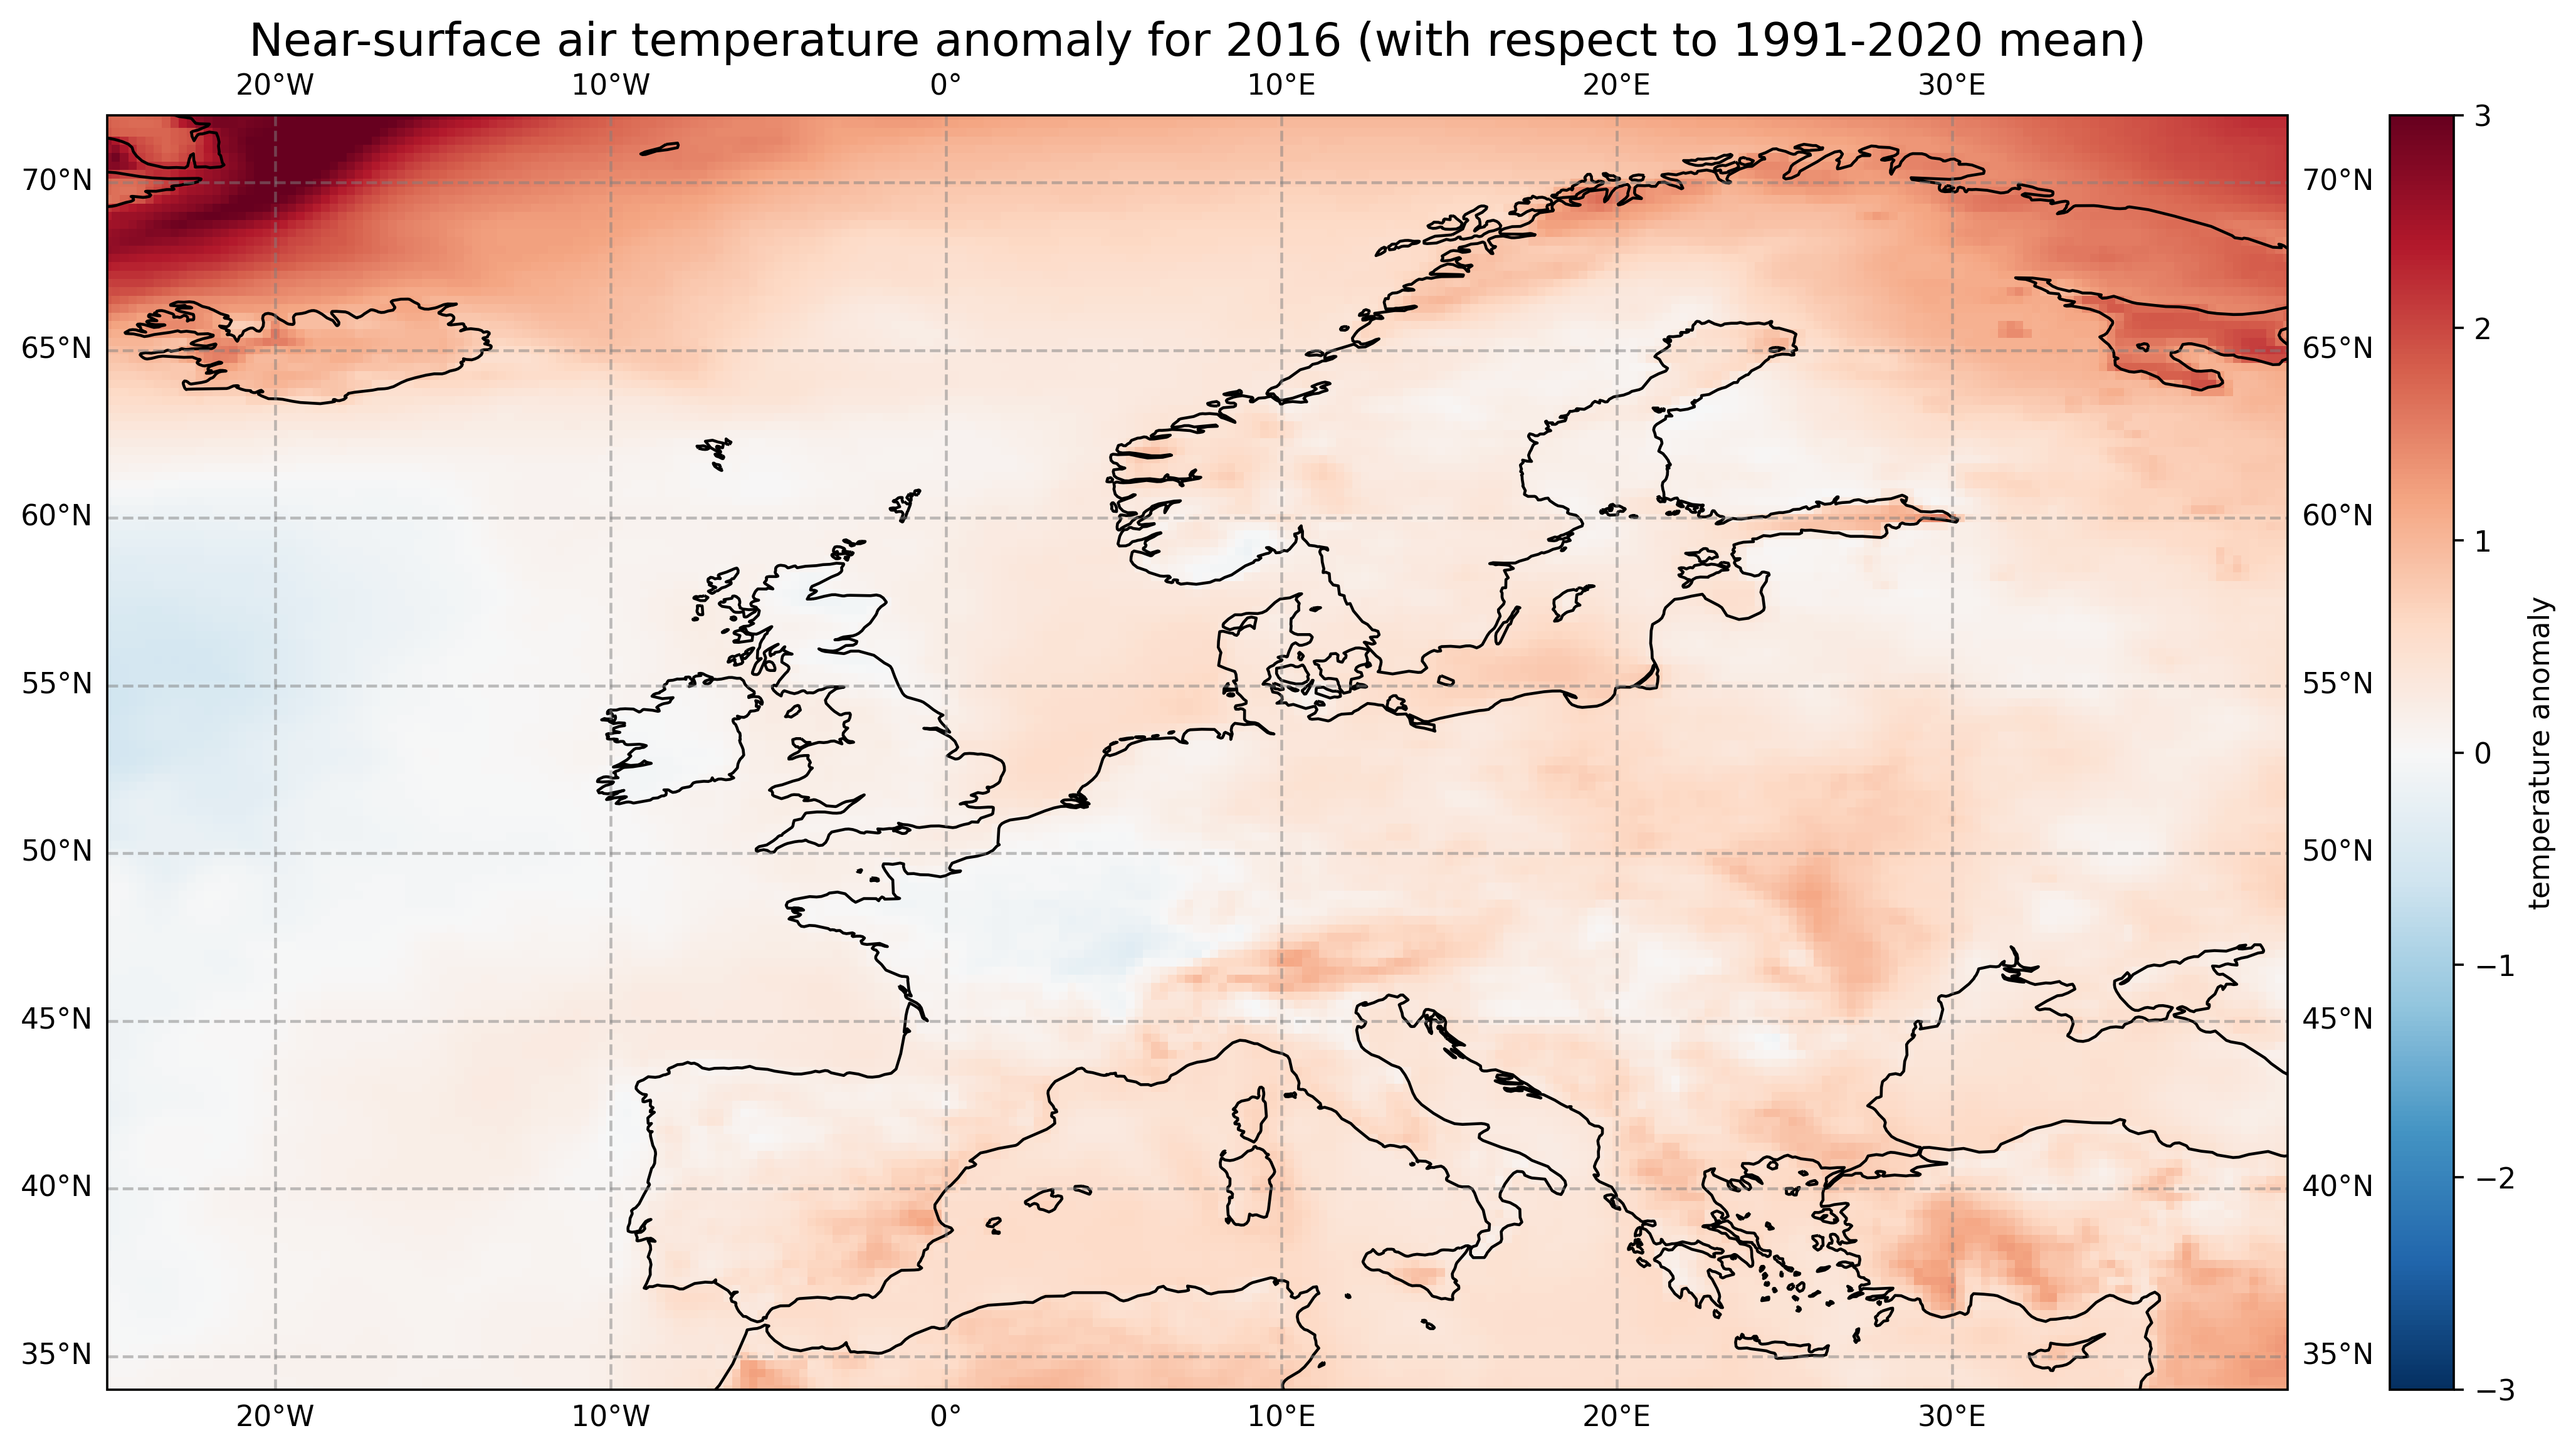

In [9]:
# create the figure panel and the map using the Cartopy PlateCarree projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), dpi=330,subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(anom_2016.longitude, anom_2016.latitude, anom_2016, cmap='RdBu_r', vmin=-3, vmax=3) 

# Set the figure title, add lat/lon grid and coastlines
ax.set_title('Near-surface air temperature anomaly for 2016 (with respect to 1991-2020 mean)', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature anomaly') 

# Save the figure
fig.savefig('ERA5_global_2016_anomaly_eur.png')

- 计算每月气候和异常

我们现在将计算 1991 年至 2020 年期间近地表气温的月气候特征。我们还将查看特定月份的气候异常。为此，我们返回到第 1 节末尾创建的数据数组。

- 我们首先再次创建 1991 年至 2020 年期间的时间子集，但这次保留每月的时间分辨率。

In [10]:
clim_period = da_degc.sel(valid_time=slice('1991-01-01', '2020-12-01'))
clim_month = clim_period.groupby('valid_time.month').mean()
clim_month

<xarray.DataArray 't2m' (month: 12, latitude: 153, longitude: 261)> Size: 2MB
array([[[-21.375422  , -19.634861  , -18.687403  , ...,  -2.3473592 ,
          -2.371643  ,  -2.4017212 ],
        [-21.481476  , -19.709276  , -17.942867  , ...,  -2.2206013 ,
          -2.251005  ,  -2.2820597 ],
        [-17.49762   , -17.198141  , -16.702827  , ...,  -2.096708  ,
          -2.1161742 ,  -2.1406534 ],
        ...,
        [ 17.290792  ,  17.27139   ,  17.251013  , ...,   7.5487347 ,
           7.6869507 ,   7.834086  ],
        [ 17.388384  ,  17.368721  ,  17.345089  , ...,   7.329203  ,
           7.524646  ,   7.739555  ],
        [ 17.475166  ,  17.456743  ,  17.434933  , ...,   7.1443725 ,
           7.3407917 ,   7.596586  ]],

       [[-22.086296  , -20.46032   , -19.546387  , ...,  -2.805239  ,
          -2.8332336 ,  -2.8705382 ],
        [-22.169369  , -20.513966  , -18.863508  , ...,  -2.6969056 ,
          -2.7344706 ,  -2.7724264 ],
        [-18.332846  , -18.131153  , -17.711882  , ...,  -2.5811503 ,
          -2.6112936 ,  -2.6467102 ],
...
        [ 19.615866  ,  19.593143  ,  19.571333  , ...,  13.895879  ,
          14.110202  ,  14.310528  ],
        [ 19.720617  ,  19.698286  ,  19.675436  , ...,  13.644642  ,
          13.905384  ,  14.153757  ],
        [ 19.814173  ,  19.796465  ,  19.774458  , ...,  13.398614  ,
          13.650241  ,  13.964108  ]],

       [[-21.140764  , -19.377422  , -18.457241  , ...,  -1.0039856 ,
          -1.0124491 ,  -1.0324361 ],
        [-21.362574  , -19.567394  , -17.777426  , ...,  -0.8465637 ,
          -0.86726683,  -0.88777465],
        [-17.380877  , -17.056526  , -16.529703  , ...,  -0.7082174 ,
          -0.7132955 ,  -0.72254026],
        ...,
        [ 18.260466  ,  18.24484   ,  18.226025  , ...,   8.883905  ,
           9.033449  ,   9.204218  ],
        [ 18.35324   ,  18.337809  ,  18.319386  , ...,   8.754348  ,
           8.956692  ,   9.154868  ],
        [ 18.437614  ,  18.425179  ,  18.41014   , ...,   8.602785  ,
           8.797446  ,   9.048618  ]]], dtype=float32)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 1kB 72.0 71.75 71.5 71.25 ... 34.5 34.25 34.0
  * longitude  (longitude) float64 2kB -25.0 -24.75 -24.5 ... 39.5 39.75 40.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      39933
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    ° C
    standard_name:                            unknown
    GRIB_surface:                             0.0

- 查看整个欧洲地区每月的平均气候。
- 问题：如何将时空数据加权转换为单纯时间数据？

> 我们想看整个欧洲每个月的平均天气情况。但直接“平均”所有数据点时有个关键不足之处：地球是圆的，地图上的小方格（网格）在不同纬度的实际面积不一样。比如，赤道附近的网格实际覆盖的地面更大，而靠近北极的网格实际面积更小。如果直接平均，高纬度的小网格会“占便宜”，让结果不准。

解决办法（补偿不同纬度处网格面积的差异）：

用一个数学小技巧——用“纬度的余弦值”来调整权重。简单来说，纬度越高（比如接近北极），余弦值越小，就给它更小的权重；纬度越低（比如赤道附近），余弦值越大，权重就更大。这样就能让面积大的地方“贡献”更多，面积小的地方“贡献”少一些，最终算出的平均值才更准确

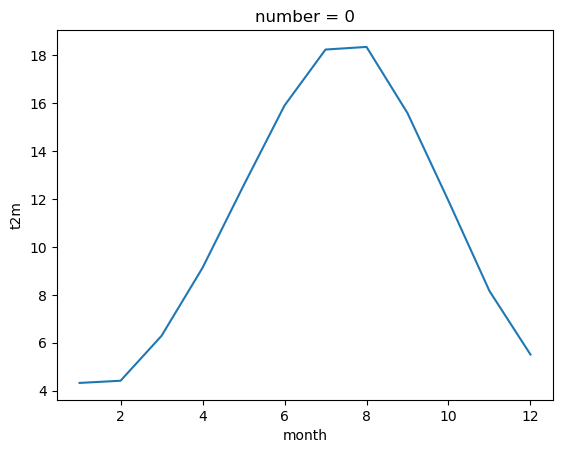

In [25]:
#np.deg2rad函数将纬度坐标从度转换为弧度
weights = np.cos(np.deg2rad(clim_month.latitude))
weights.name = "weights"
clim_month_weighted = clim_month.weighted(weights)
mean = clim_month_weighted.mean(["longitude", "latitude"])
mean.plot()

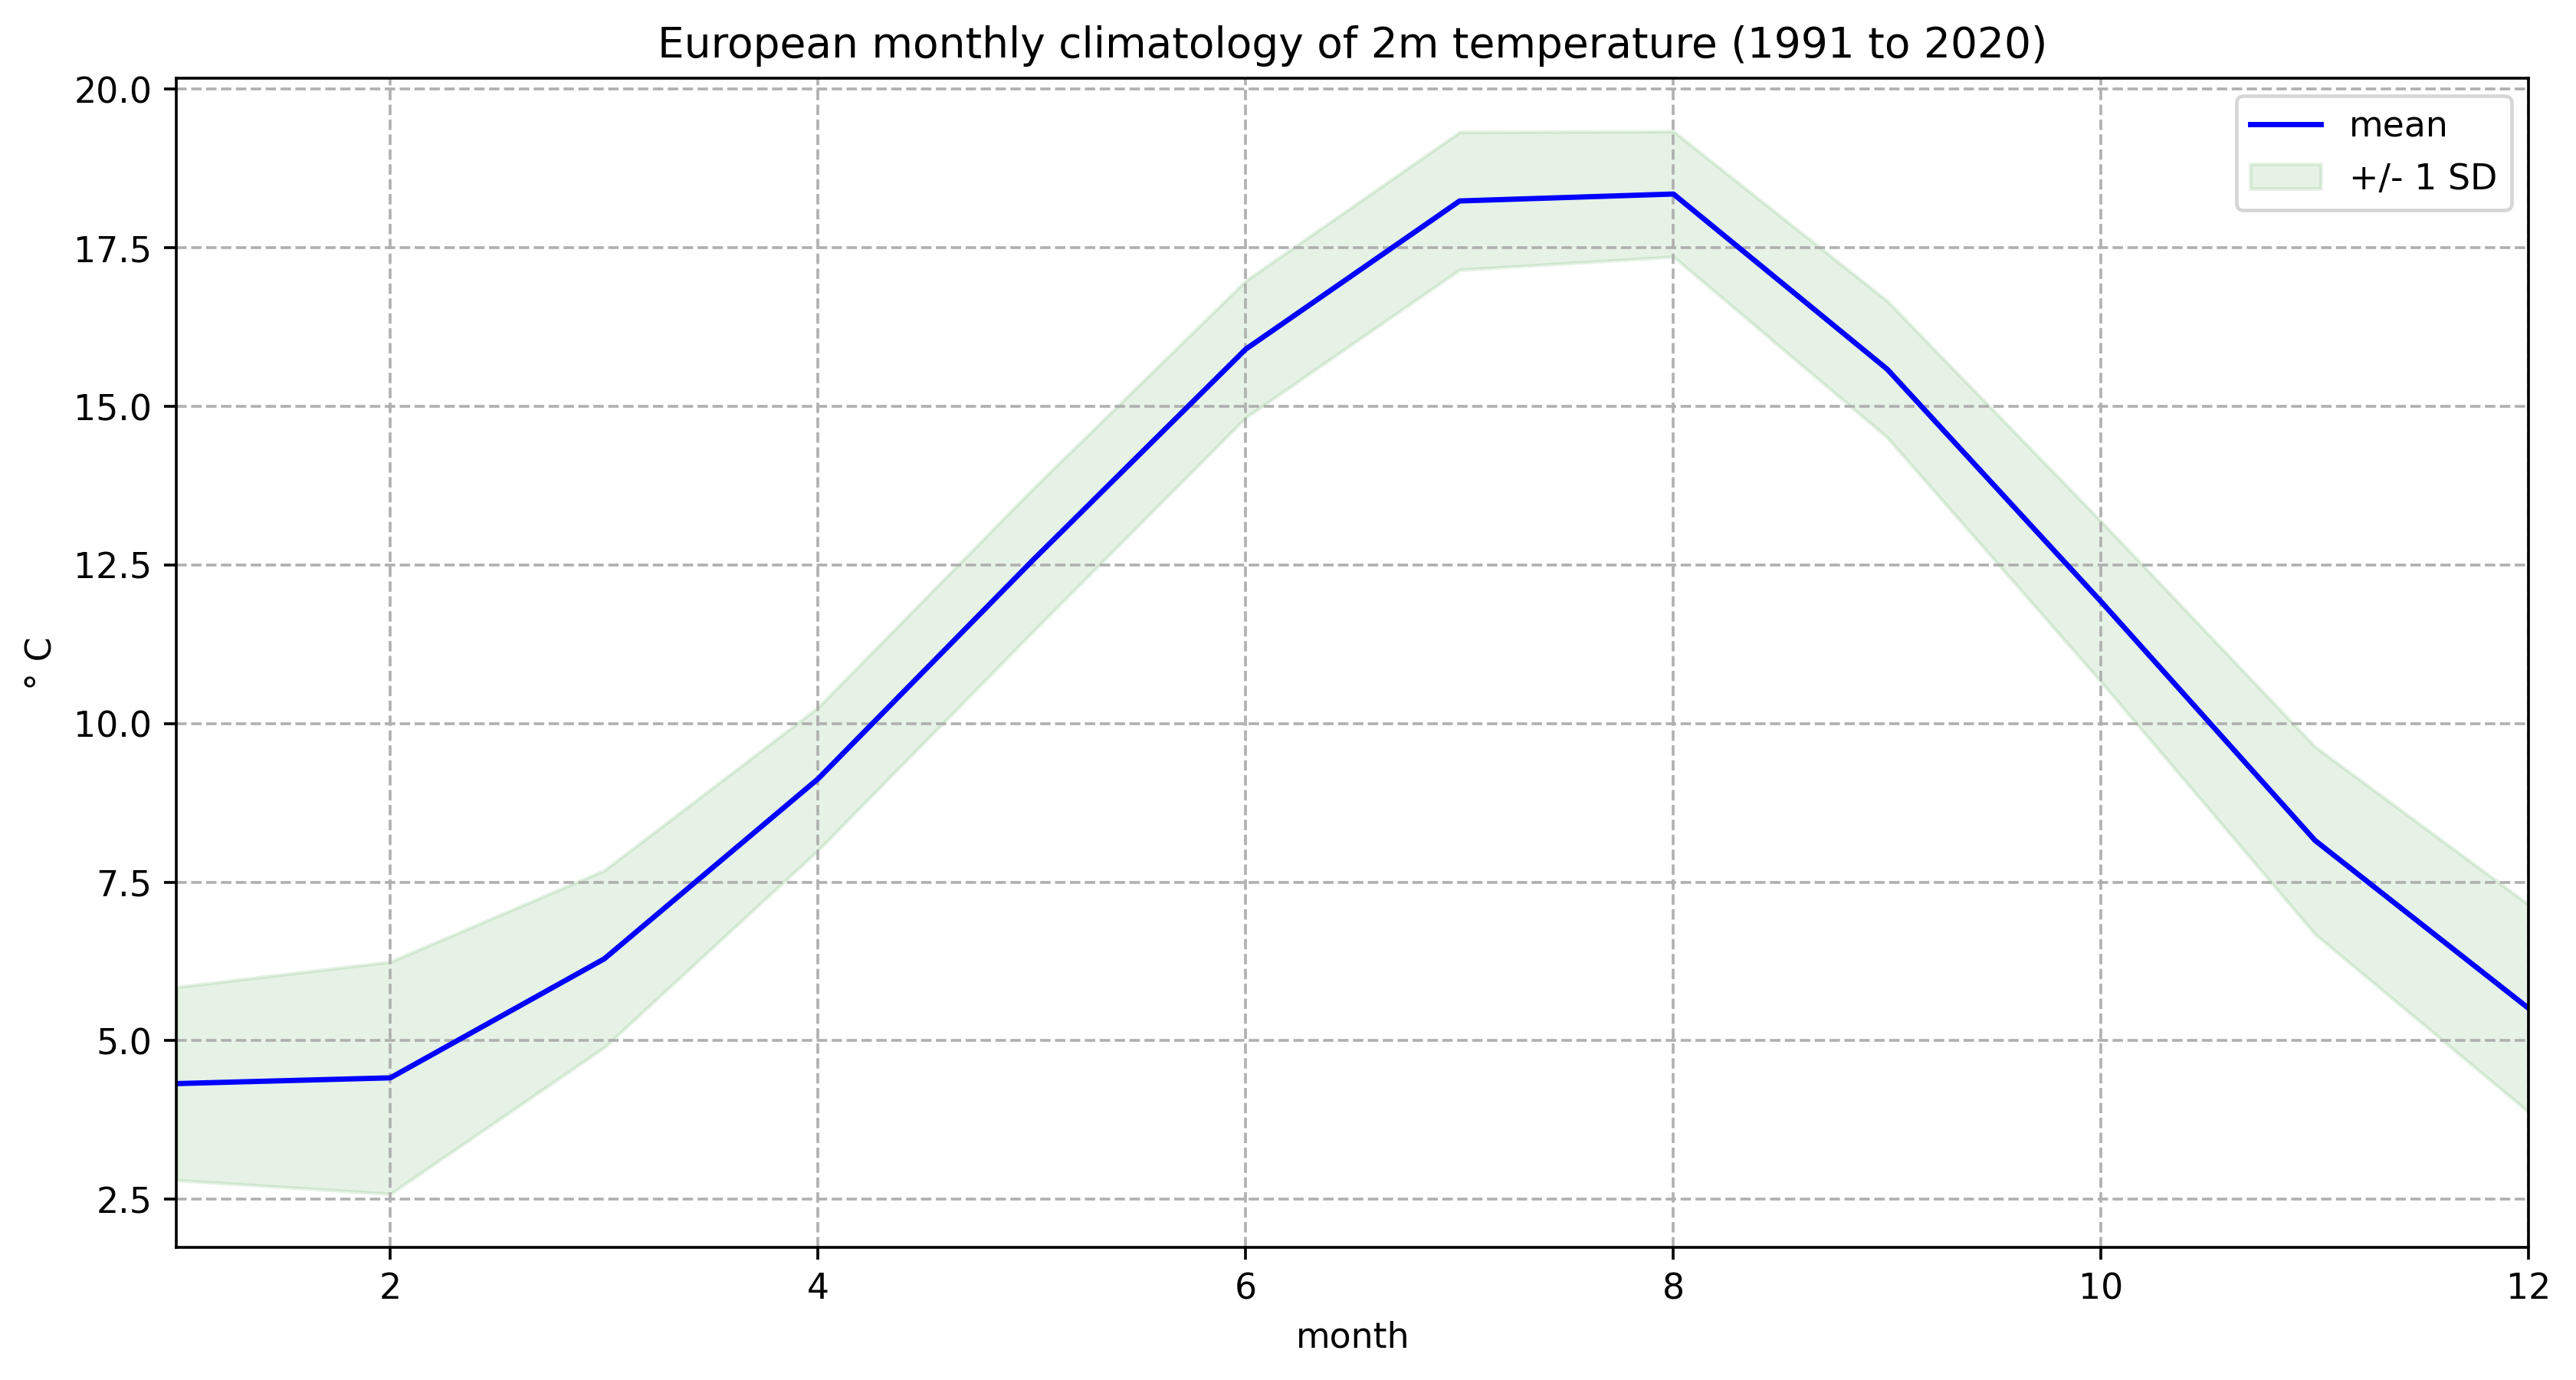

In [ ]:
#同样的流程计算一下标准差
clim_std = clim_period.groupby('valid_time.month').std()
weights = np.cos(np.deg2rad(clim_std.latitude))
weights.name = "weights"
clim_std_weighted = clim_std.weighted(weights)
std = clim_std_weighted.mean(["longitude", "latitude"])
#绘图与保存
fig, ax = plt.subplots(1, 1, figsize = (12, 6),dpi=330)
ax.plot(mean.month, mean, color='blue', label='mean')
ax.fill_between(mean.month, (mean + std), (mean - std), alpha=0.1, color='green', label='+/- 1 SD')
ax.set_title('European monthly climatology of 2m temperature (1991 to 2020)')
ax.set_ylabel('° C')
ax.set_xlabel('month')
ax.set_xlim(1,12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')
fig.savefig('./Eur_monthly_t2m_clim.png')

- 计算每月异常值
  
现在，我们将检查与此气候相关的月度异常。我们将返回到按纬度和经度聚合之前创建的数据。我们可以通过从中减去月度气候来计算原始欧洲时间序列每个月的月度异常。

In [28]:
anom_month = da_degc.groupby('valid_time.month') - clim_month

- 可视化特定月份的欧洲近地表温度异常

最后一步是可视化欧洲某个特定月份的气温异常场。在欧洲，2020 年是有记录以来最热的一年，西北地区在 7 月下半月和 8 月上半月经历了热浪。让我们选择 1979 年至 2020 年每年 8 月的气温异常。

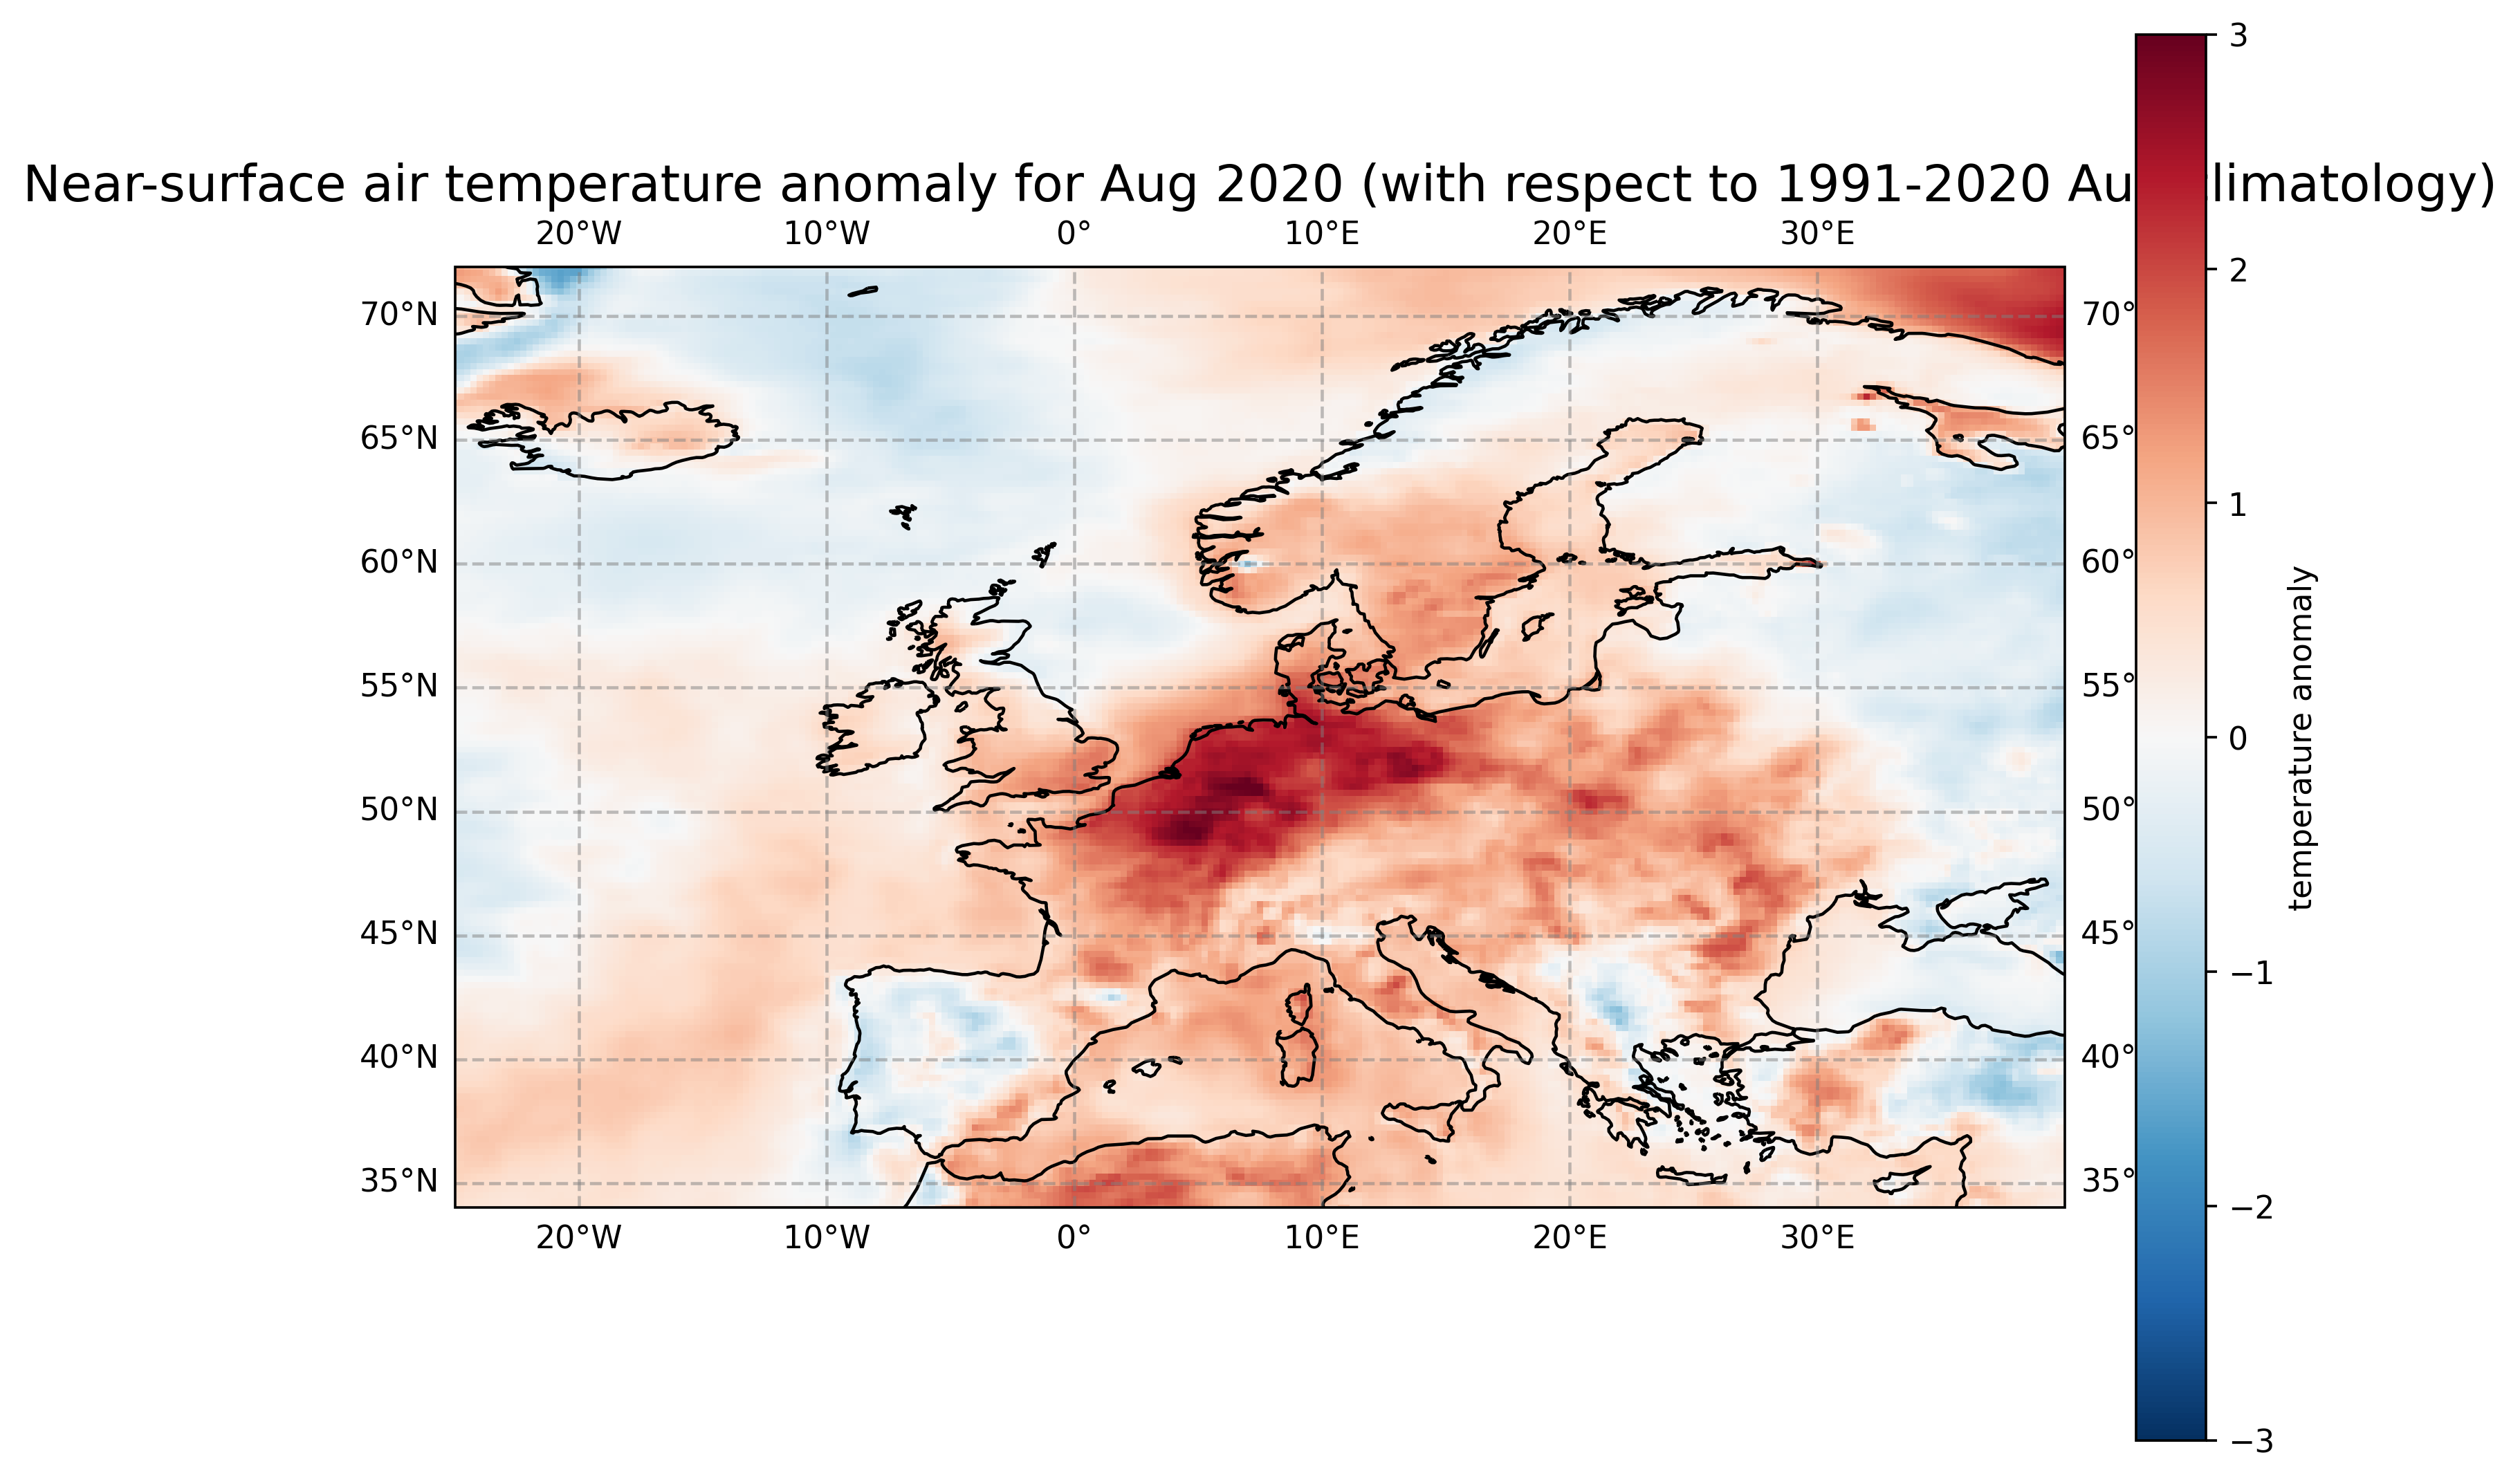

In [30]:
anom_aug = anom_month[anom_month.month == 8]
#可视化 2020 年 8 月欧洲的近地表气温异常情况
fig, ax = plt.subplots(1, 1, figsize = (10, 8),dpi=330, subplot_kw={'projection': ccrs.PlateCarree()})
im = plt.pcolormesh(anom_aug.longitude, anom_aug.latitude, anom_aug[41,:,:], cmap='RdBu_r', vmin=-3, vmax=3) 
ax.set_title('Near-surface air temperature anomaly for Aug 2020 (with respect to 1991-2020 Aug climatology)', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature anomaly') 
fig.savefig('./ERA5_Europe_2020-08_anomaly.png')

#### 时间序列分析

本节我们将重点介绍时间序列分析，绘制并分析近地表气温随时间的变化。我们重点介绍北极的另一个子区域，该区域的温度上升尤为明显。

我们将下载数据集ERA5 的另一个子集，即 1979 年至今的单层月平均数据，这次是针对北极的。[数据链接](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview)

In [ ]:
import cdsapi
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["2m_temperature"],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [90, -180, 66.55, 180]
}
client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-03-17 21:53:36,640 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-17 21:53:36,642 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-17 21:53:38,224 INFO Request ID is 54906219-30de-4fbf-a4f8-25acc88d507a
2025-03-17 21:53:38,808 INFO status has been updated to accepted
2025-03-17 22:24:29,501 INFO status has been updated to successful


'cbbbf67eb8b5270df5ca1352260cc6bd.nc'

- 仿照之前流程：

In [72]:
#文件I/O
Arc_file=r'./cbbbf67eb8b5270df5ca1352260cc6bd.nc'
Arc_ds = xr.open_dataset(Arc_file)
#经度转换
Arc_180 = Arc_ds.assign_coords(longitude=(((Arc_ds.longitude + 180) % 360) - 180)).sortby('longitude')
# Create Xarray Data Array
Arc_da = Arc_180['t2m']
#开尔文转换摄氏度
Arc = Arc_da - 273.15
Arc = Arc.assign_attrs(Arc_da.attrs)
Arc.attrs['units'] = '° C'

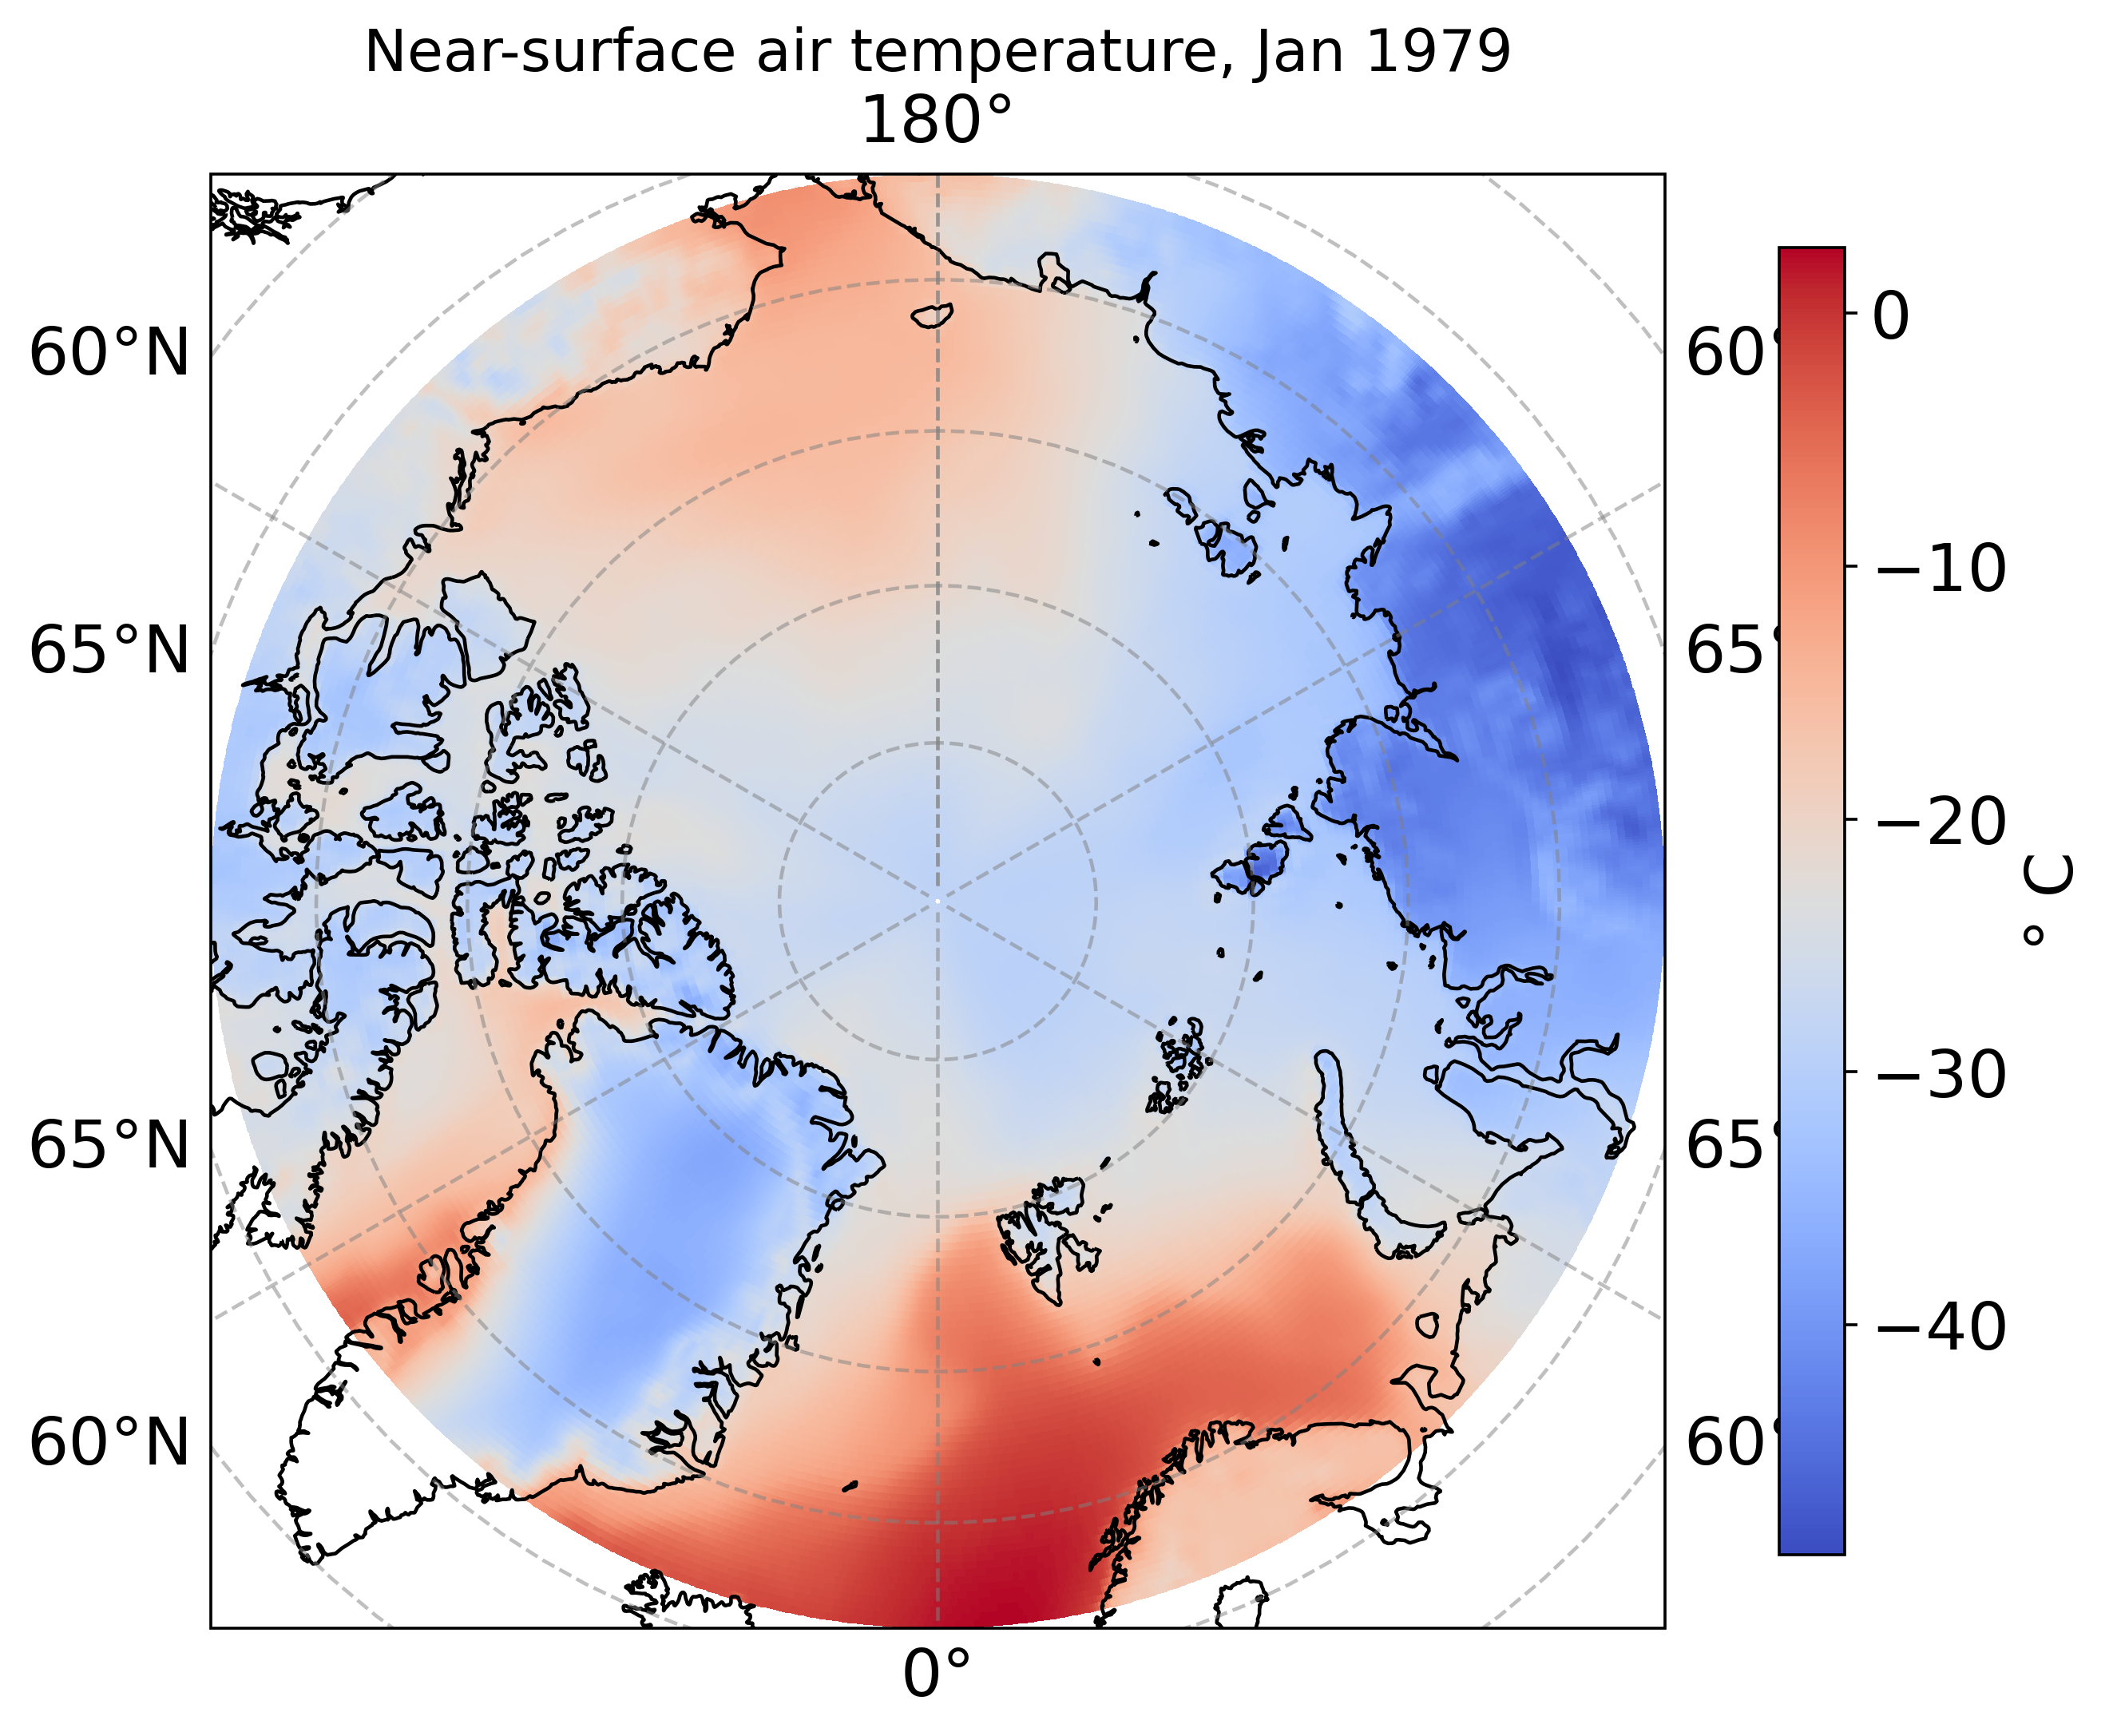

In [73]:
#基本可视化（1979年时空数据（地面2m温度））
fig, ax = plt.subplots(1, 1, figsize = (8, 8),dpi=330, subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})
im = ax.pcolormesh(Arc.longitude, Arc.latitude, Arc[0,:,:], transform = ccrs.PlateCarree(), cmap='coolwarm')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('Near-surface air temperature, Jan 1979', fontsize=16)
ax.coastlines(color='black')
cbar = fig.colorbar(im, fraction=0.04, pad=0.07)
cbar.set_label('° C')
fig.savefig('./ERA5_Arctic_t2m_Jan1979.png')

- 按地理纬度/经度维度进行汇总(查看整个北极空间温度，将时空数据转换单纯时间数据)
- 想分析北极地区近地表气温的时间序列。为此需要对纬度和经度维度进行平均。和以前一样，需要考虑网格数据单元随纬度变化的大小（补偿不同纬度处网格面积差异）
- 最后空间分辨率归一为一体（北极），时间分辨率聚类为年均，进行可视化

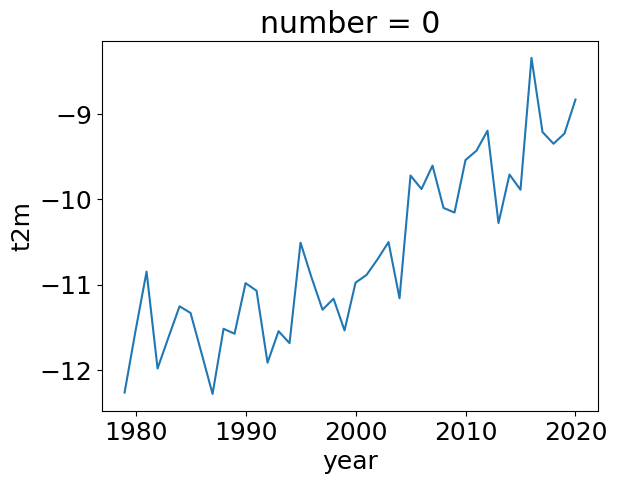

In [74]:
weights=np.cos(np.deg2rad(Arc.latitude))
weights.name='weights'
Arc_weighted=Arc.weighted(weights)
Arc_mean=Arc_weighted.mean(['longitude','latitude'])
Arc_yearly = Arc_mean.groupby('valid_time.year').mean()
Arc_yearly.plot()

这里我们可以看到明显的变暖趋势。

> 查看此类时间序列的典型方法是将绝对温度值转换为相对于气候正常的异常值，并将时间序列视为条形图。这可以清楚地突出显示哪些年份的平均温度高于或低于气候正常值。

为此，我们计算相对于气候正常的异常值(参考背景时间为1991-2020年)

In [75]:
Arc_ref = Arc_yearly.where((Arc_yearly.year > 1990) & (Arc_yearly.year < 2021), drop=True)
Arc_clim = Arc_ref.mean()
Arc_anom = Arc_yearly - Arc_clim
df = Arc_anom.to_dataframe()
df['positive'] = df['t2m'] > 0
df

number       t2m  positive
year                            
1979       0 -1.990022     False
1980       0 -1.263204     False
1981       0 -0.570733     False
1982       0 -1.707727     False
1983       0 -1.338907     False
1984       0 -0.977705     False
1985       0 -1.055750     False
1986       0 -1.528566     False
1987       0 -2.006015     False
1988       0 -1.241478     False
1989       0 -1.299498     False
1990       0 -0.705877     False
1991       0 -0.794336     False
1992       0 -1.639314     False
1993       0 -1.269870     False
1994       0 -1.410399     False
1995       0 -0.231174     False
1996       0 -0.639765     False
1997       0 -1.017945     False
1998       0 -0.888362     False
1999       0 -1.260877     False
2000       0 -0.700583     False
2001       0 -0.609446     False
2002       0 -0.426062     False
2003       0 -0.223880     False
2004       0 -0.882698     False
2005       0  0.557282      True
2006       0  0.398627      True
2007       0  0.673659      True
2008       0  0.177418      True
2009       0  0.122493      True
2010       0  0.739084      True
2011       0  0.849170      True
2012       0  1.083496      True
2013       0 -0.000786     False
2014       0  0.568871      True
2015       0  0.390217      True
2016       0  1.937533      True
2017       0  1.068437      True
2018       0  0.930297      True
2019       0  1.050522      True
2020       0  1.448391      True

- 最后进行可视化与美观

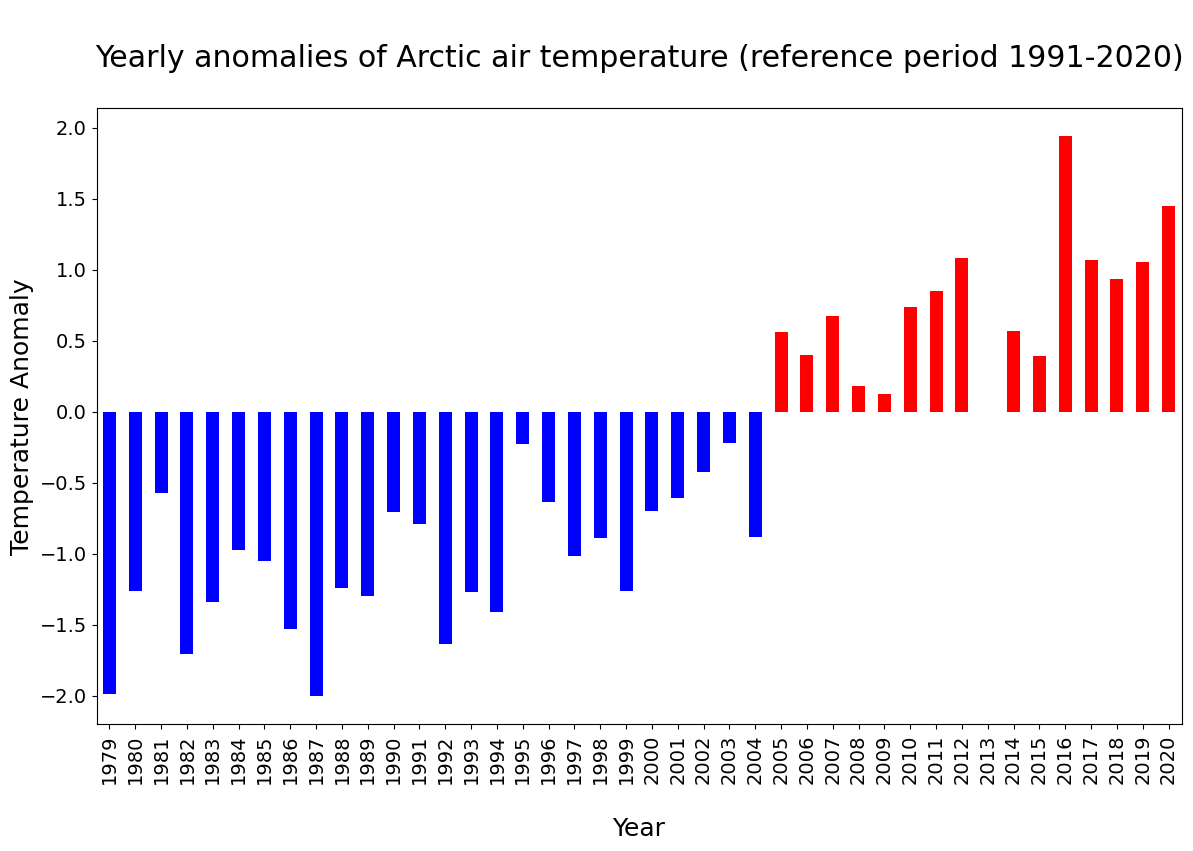

In [76]:
plt.rcParams.update({'font.size': 18}) # must set in top
df['t2m'].plot(
    figsize=(14,8),
    kind='bar',
    color=df.positive.map({True: 'red', False: 'blue'}),
    fontsize=14,
    xlabel='\nYear',
    ylabel='Temperature Anomaly',
    title='\nYearly anomalies of Arctic air temperature (reference period 1991-2020)\n',
    )
plt.savefig('./Arctic_t2m_anom_bar.png',dpi=330)

#### 北极近地表气温的季节性分析

我们将比较北极近地表气温的季节性趋势。为此，我们返回到每月地理平均数据集，并使用函数将月平均值下采样为季节平均值resample()。通过指定time='QS-DEC'，数据被分成连续的三个月周期，以 12 月为基准。如果我们另外添加函数mean()，我们将计算三个月周期的平均值

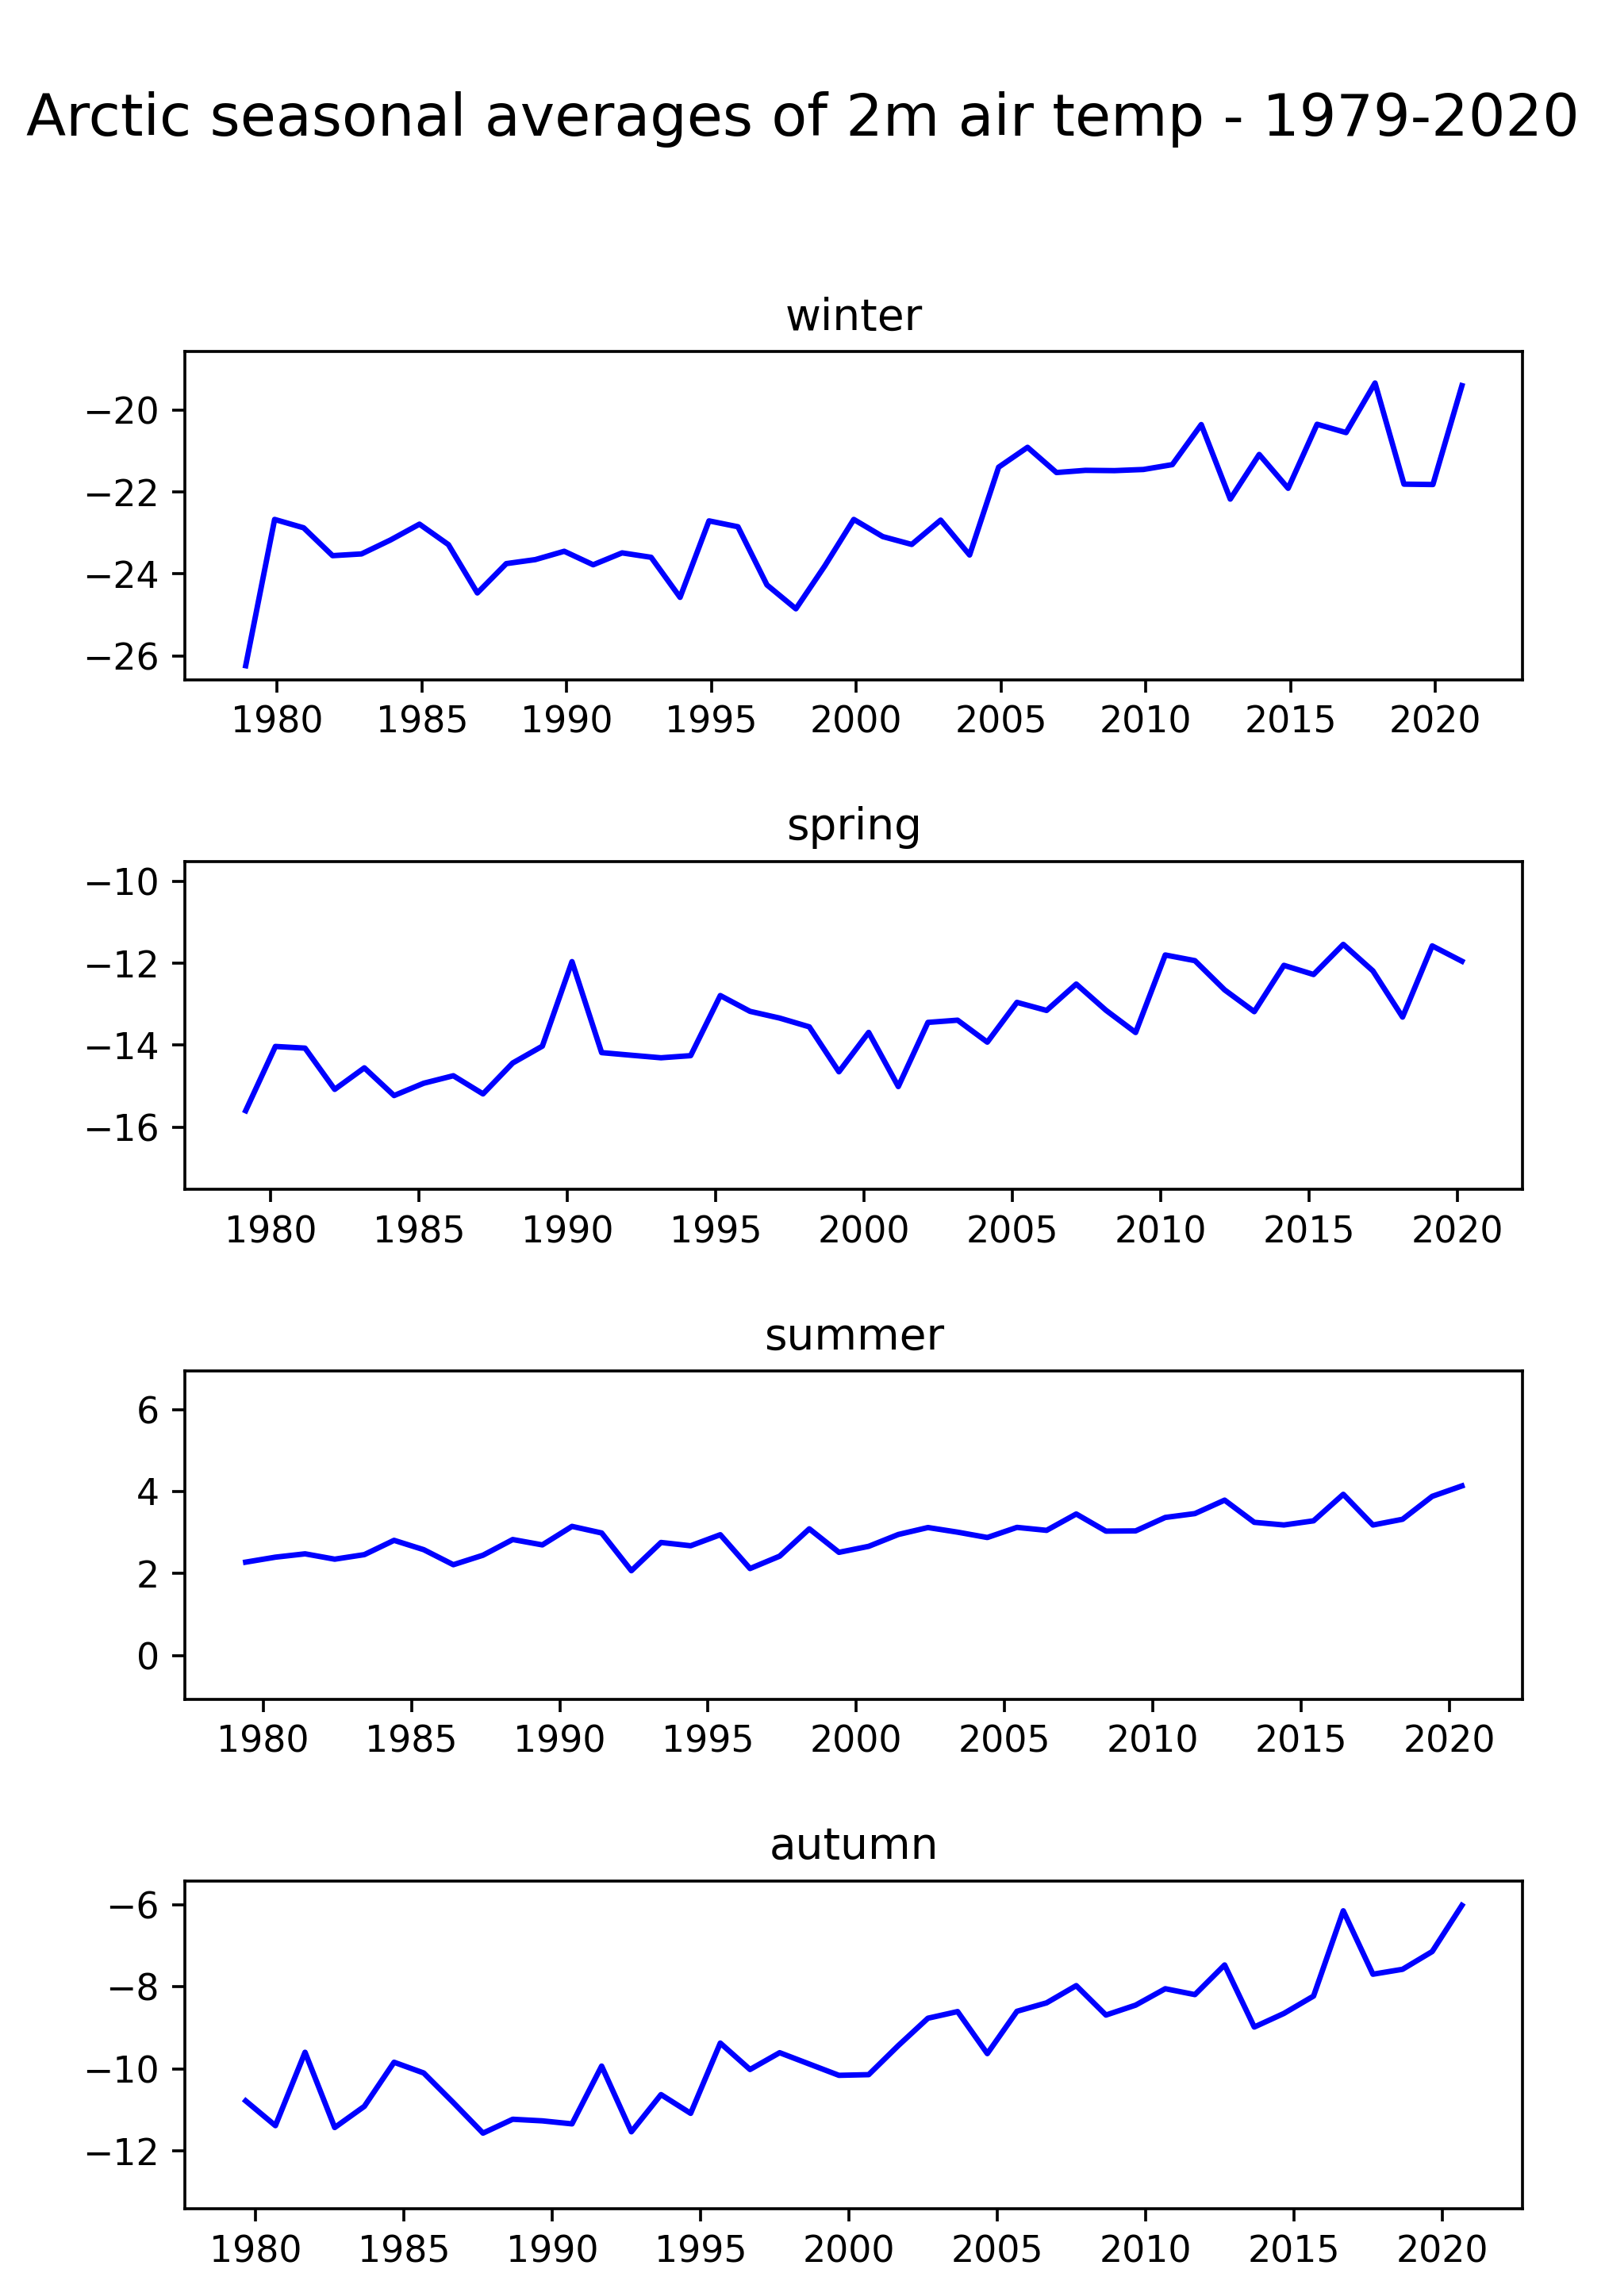

In [94]:
#resample 是 xarray 中用于时间序列数据重采样方法,允许根据时间维度上的规则重新划分数据。
#'QS-DEC' 是频率字符串,'Q' 表示季度。
Arc_seasonal = Arc_mean.resample(valid_time='QS-DEC').mean()
#绘图可视化
fig, axs = plt.subplots(4, 1, figsize = (6, 9),dpi=330)
season_list = ["winter", "spring", "summer", "autumn"]
for i in range(4):
    df = Arc_seasonal[i::4].to_dataframe()
    mid_range = df['t2m'].mean()
    axs[i].plot(df.t2m, color='blue')
    axs[i].set_ylim([mid_range-4, mid_range+4])
    axs[i].set_title(season_list[i], fontsize=12)
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)

fig.suptitle('\nArctic seasonal averages of 2m air temp - 1979-2020\n', fontsize=16)
fig.tight_layout(pad=1.0)

fig.savefig('./Arctic_seasonal.png')

- 请注意北极季节平均气温变化的差异：与其他季节相比，夏季平均气温似乎更加恒定